In [0]:
import sys
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import time

In [0]:
def PDE1d_plotting_black(t,z,y,t_interval=10, title_str = 'PDE result',ylim  = None):
  line_len = [1,3,5]
  space_len = [1,2,4]
  L_styles = [(0,())]
  for line in line_len:
    for space in space_len:
      style_temp = (line, space)
      L_styles.append((0,style_temp))
  indx_t = 0;
  indx_style = 0
  fig1 = plt.figure(figsize = (8,5))
  while indx_t < np.size(t):
    plot_temp, = plt.plot(z,np.array(y[indx_t]),
                         linestyle= L_styles[indx_style], linewidth=2, color = 'black')
    plot_temp.set_label('t={}'.format(t[indx_t]))
    indx_t = indx_t + t_interval
    
    if indx_style < len(L_styles)-1:
      indx_style = indx_style + 1
    else:
      indx_style = 0
  plt.legend(bbox_to_anchor=(1.,1.));
  plt.title(title_str)
  plt.grid()
  if not(ylim == None):
      plt.ylim(ylim)
  plt.show()



# [1] Parameters

In [0]:
L = 0.4     # Length (m)
D_inn = 0.1 # Inner diameter (m)
N = 20+1     # Number of node
# overall
D_diff = 1E-8   # diffusivity (m^2/sec)
mu =  1.849E-5  # viscosity(kg/m/sec)
rho_g = 1.18 # gas density (kg/m^3) 
rho_ad = 400 # solid density (kg/m^3)
epsi = 0.4
# heat related
Cp_g = 1000  # heat capacity of gas (J/kg/K)
Cp_ad = 1000 # heat capacity of adsorber (J/kg/K)
k_th = 0.02 # thermal conductivity of gas (W/m/K)
Delta_H = 40E3 # heat of adsorption (W/mol)
# mass related
k_ov = 20 # mass transfer coefficient (1/sec)
b_fn = lambda T:2.5E-5*np.exp(Delta_H/8.3145*(1/T - 1/300)) # Langmuir para (1/Pa)
q_m_fn = 2.0 # (mol/kg)
#f_isotherm = lambda P,T: q_m_fn*b_fn(T)*P/(1+b_fn(T)*P) 

#### Different isotherm model
### 1) Toth isotherm
#f_isotherm = lambda P,T: q_m_fn*b_fn(T)*P/(1+(b_fn(T)*P)**2)**(1/2) 
### 2) Langmuir Freundlich isotherm model
#f_isotherm = lambda P,T: q_m_fn*(b_fn(T)*P)**(1/2)/(1+(b_fn(T)*P)**(1/2))

#### Test f_isotherm
#P_test = np.arange(0,1E5)
#T_test = 300
#q_test = f_isotherm(P_test,T_test) 
#plt.plot(P_test, q_test)

# [2] BC and IC

In [0]:
# Boundary conditions
# Standard ambient temperature and presssure (SATP)
T_in = 298.15   # K
#P_in = 1.013e5  # Pa
R = 8.314462    # J/mol/K 
P_out = 1.013e5 # Pa
# Linear velocity of inlet flow:
v0 = 0.05

# Update the inlet pressure from its visocisity
P_DELTA = 32*mu/D_inn**2*v0*L
P_in = P_out + P_DELTA

y_in = 0.04
C0 = y_in*P_in/R/T_in # mol/m^3
C_inner0 = (1-y_in)*P_in/R/T_in # mol/m^3

BC = [C0,C_inner0, T_in]

## Initial conditions
C_ic = 0*P_in/R/T_in*np.ones(N)
q_ic = np.zeros(N)
Cin_ic = 1*P_in/R/T_in**np.ones(N)
T_ic = 0.9*T_in*np.ones(N)
y0 = np.concatenate((C_ic,q_ic,Cin_ic,T_ic))    # No gas A
#y0[N:2*N] = P_in/R/T_in # Full of inert gas

# [3] Discretization

In [0]:
z=np.linspace(0,L,N);

ones_diag = np.ones(N)
h_sq = ((L/(N-1))**2)*(ones_diag)
h = (L/(N-1))*ones_diag

dd1 = np.diag(1/h_sq[:-1],k=1)
dd2 = np.diag(-2/h_sq);
dd3 = np.transpose(dd1);

dd_tot = dd1 + dd2 +dd3
dd_tot[0,:2] = 0
dd_tot[-1,-1] = -(1/h_sq[-1])

d1 = np.diag(-1/h[:-1], k = -1)
d2 = np.diag(1/h)
d_tot = d1 + d2
dz = h[-1];
d_tot[-1,-4:] = 1/dz, -3/dz, 2/dz, 0
#d_tot[-1,:] = d_tot[-1,:]

# [4] PDE eqn format

In [0]:
#### [[function to be used in ode solver]] ###
def ODE_form(y,t,d,dd,boundary,v_inlet, P_outlet):
  # Distribute
  C = y[0:N]
  q = y[N:2*N]
  C_iner = y[2*N:3*N]
  T = y[3*N:4*N]
  # Boundary conditions
  C_b, C_iner_b,T_b = boundary
  C[0] = C_b
  T[0] = T_b
  C_iner[0] = C_iner_b
  # Pressure
  P = (C+C_iner)*R*T
  P_a = C*R*T # Partial pressure of component A
  delz = z[1]-z[0] ### 
  delP = 32*mu/D_inn**2*v_inlet*delz ### v_inlet
  P[0] = P[1] + delP ### P
  # Velocity
  v = -D_inn**2/32/mu*np.array(d@P) ### v, d
  v[0] = v_inlet ###
  # Differentiate
  ddC = np.array(dd@C)
  dC = np.array(d@C)
  ddT = np.array(dd@T)
  dT = np.array(d@T)
  ddC_iner = np.array(dd@C_iner)
  dC_iner = np.array(d@C_iner)
  dv = -D_inn**2/32/mu*np.array(dd@P) #### dv, dd
  dv[-1] = -D_inn**2/32/mu*(P_outlet - 2*P[-1]+P[-2])/(delz**2) ### P_outlet
  ######### 
  # Solid phase ### [We need: isotherm parameters for f_isotherm, k_ov, and rho_ad]
  q_eq = f_isotherm(P_a,T)
  dqdt = k_ov *(q_eq-q)
  # Gas A
  dCdt = (D_diff*ddC - v*dC - C*dv) - rho_ad*dqdt
  dCdt[0] = 0
  # Inert gas
  dC_inerdt = (D_diff*ddC_iner - v*dC_iner - C_iner*dv)
  dC_inerdt[0] = 0
  ###########
  # Temperature ### [We need: rho_g, Cp_g, k_th, Q_gen (= h*delT) ]
  Q_gen = (1-epsi)*Delta_H*rho_ad*dqdt
  dTdt = 1/(epsi*rho_g*Cp_g+(1-epsi)*rho_ad*Cp_ad)*(+ Q_gen -k_th*ddT)  - v*dT - T*dv
  dTdt[0] = 0
  # Concatenate
  dydt_temp = (dCdt,dqdt, dC_inerdt,dTdt)
  dydt = np.concatenate(dydt_temp, axis=0)
  return dydt

# [5] Solve ODE

In [0]:
# Time
tic = time.time()
t_end = 200
t_mesh = 1/4000 
#N_t = 40000*4 +1
t = np.linspace(0,t_end,N_t)
t = np.arange(0,t_end+t_mesh, t_mesh)
y= odeint(ODE_form, y0, t,args= (d_tot,dd_tot,BC,v0,P_out))
toc = time.time() - tic
print(' CPU time: {0:.3f}min'.format(toc/60))

 CPU time: 1.508min


# [6] Recalculate Pressure

In [0]:
C_result = y[:,0:N]
q_result = y[:,N:2*N]
C_inner_result = y[:,2*N:3*N]
T_result = y[:,3*N:4*N]
P_recal = (C_result + C_inner_result)*R*T_in
y_mol_result = C_result/ (C_result + C_inner_result)

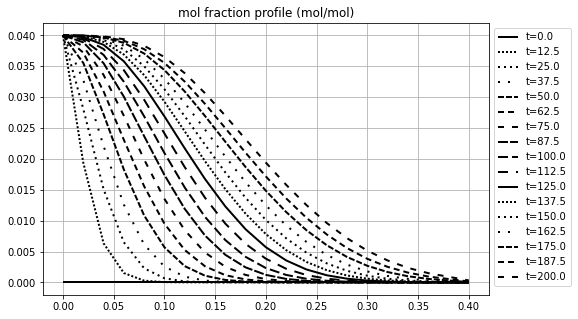

In [0]:
#PDE1d_plotting_black(t[100:],z,P_recal[100:,:]/1E5,
#                     t_interval = 200,
#                     title_str = 'Pressure Profile (bar)',
#                     ylim = [1.0125,1.0135])
PDE1d_plotting_black(t[:],z,y_mol_result,t_interval = 50000,
                     title_str = 'mol fraction profile (mol/mol)')

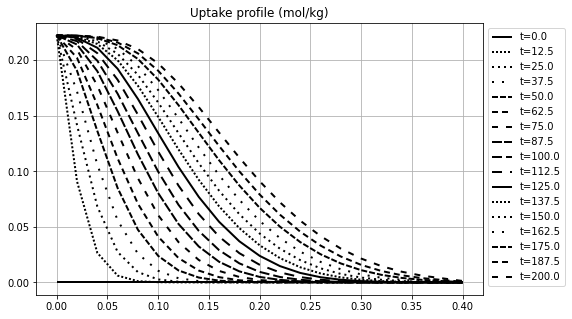

In [0]:
PDE1d_plotting_black(t[:],z,q_result,t_interval = 50000,
                     title_str = 'Uptake profile (mol/kg)')

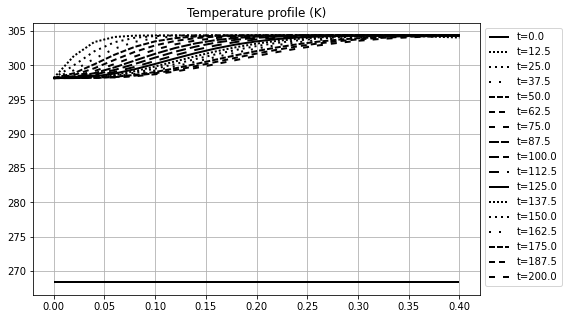

In [0]:
PDE1d_plotting_black(t[:],z,T_result,t_interval = 50000,
                     title_str = 'Temperature profile (K)')